# NFL Fantasy Football Rookie Success Analysis and Visualization Notebook

## Task 1: Install necessary packages and grab initial data

In [ ]:
pip install seaborn pandas matplotlib pathllib

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

Ingest the running_backs_2015_2025.csv file from data ingestion and cleaning notebook output for data analysis and visualization

In [ ]:
downloads_path = Path.home() / "Downloads"
file_name = "running_backs_2015_2025.csv"
full_file_path = downloads_path / file_name

df = pd.read_csv(full_file_path)
print(df.shape, df.columns)
df.head()

(233, 35) Index(['season', 'round', 'pick', 'team', 'pfr_player_id', 'pfr_player_name',
       'college', 'position', 'position_rank', 'ht', 'wt', 'forty', 'bench',
       'vertical', 'broad_jump', 'cone', 'shuttle', 'unique_id',
       'college_carries', 'college_tds', 'college_yards', 'college_long',
       'college_ypc', 'pfr_id', 'carries', 'rushing_yards', 'rushing_tds',
       'rushing_fumbles', 'rushing_fumbles_lost', 'receptions',
       'receiving_yards', 'receiving_tds', 'receiving_fumbles',
       'receiving_fumbles_lost', 'fantasy_points'],
      dtype='object')


,season,round,pick,team,pfr_player_id,pfr_player_name,college,position,position_rank,ht,...,rushing_yards,rushing_tds,rushing_fumbles,rushing_fumbles_lost,receptions,receiving_yards,receiving_tds,receiving_fumbles,receiving_fumbles_lost,fantasy_points
0,2015,1,10,STL,GurlTo01,Todd Gurley,Georgia,RB,RB1,6-1,...,1106.0,10.0,3.0,1.0,21.0,188.0,0.0,0.0,0.0,208.4
1,2015,1,15,SDG,GordMe00,Melvin Gordon,Wisconsin,RB,RB2,6-1,...,641.0,0.0,5.0,4.0,33.0,192.0,0.0,1.0,0.0,108.3
2,2015,2,36,JAX,YeldT.00,T.J. Yeldon,Alabama,RB,RB3,6-1,...,740.0,2.0,0.0,0.0,36.0,279.0,1.0,0.0,0.0,155.9
3,2015,2,54,DET,AbduAm00,Ameer Abdullah,Nebraska,RB,RB4,5-9,...,597.0,2.0,4.0,2.0,25.0,183.0,1.0,0.0,0.0,117.0
4,2015,3,73,ATL,ColeTe01,Tevin Coleman,Indiana,RB,RB5,5-11,...,392.0,1.0,3.0,3.0,2.0,14.0,0.0,0.0,0.0,42.6


Initially, we will be running some baseline exploratory analysis and basic correlation analysis using a heatmap to see what features are correlated highest with rookie fantasy point production.

Below, we select only the **numeric** type columns which mainly includes draft selection data, college statistics, and combine statistics.

In [ ]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
target_columns = ['round', 'pick', 'wt', 'forty', 'bench', 'vertical',
       'broad_jump', 'cone', 'shuttle', 'college_carries', 'college_tds',
       'college_yards', 'college_long', 'college_ypc', 'fantasy_points']

numeric_df = numeric_df[target_columns]

nan_percentages = numeric_df.isna().mean() * 100

dropped_na_numeric_df = numeric_df.dropna()
print('If we drop all ROWS with NaN, we would be left with', dropped_na_numeric_df.shape)
print('Below are the columns and their percentage of it as NaN')
print(nan_percentages)

If we drop all ROWS with NaN, we would be left with (52, 15)
Below are the columns and their percentage of it as NaN
round               0.000000
pick                0.000000
wt                 24.463519
forty              34.334764
bench              50.214592
vertical           34.334764
broad_jump         39.484979
cone               69.957082
shuttle            67.811159
college_carries    15.879828
college_tds        15.879828
college_yards      15.879828
college_long       15.879828
college_ypc        15.879828
fantasy_points      0.000000
dtype: float64


We can see that simply dropping all rows with NaN would take us from a sample of 233 RBs to only 52. Analyzing which columns contain the most NaN values can help us not drop as many rows by dropping the problematic columns instead. Based on the output, the cone, shuttle, and bench combine exercises contain the most NaN columns. Let's see how many rows we have if we drop those first.

In [ ]:
cleaned_columns_df = numeric_df.drop(columns=['cone', 'shuttle', 'bench'])
dropped_na_numeric_df = cleaned_columns_df.dropna()
dropped_na_numeric_df.shape

(115, 12)

We essentially doubled our number of players by dropping the top three NaN columns. This will help us get a more accurate result in our below heatmap. Some more cleaning below to achieve the most logical heatmap.

In [ ]:
# In sports analytics especially, round and pick features are coded so that the higher value
# numbers (pick 200) are worse picks. This naturally leads to negative correlation with fantasy
# points. We invert this scale in order to achieve the correct correlation direction
dropped_na_numeric_df['round_inv'] = dropped_na_numeric_df['round'].max() - dropped_na_numeric_df['round'] + 1
dropped_na_numeric_df['pick_inv'] = dropped_na_numeric_df['pick'].max() - dropped_na_numeric_df['pick'] + 1
dropped_na_numeric_df = dropped_na_numeric_df.drop(['pick', 'round'], axis=1)

# Similar to round/pick, forty yard dash time is "opposite" - higher forty time = slower (worse).
# We create 'forty_rank' that inverts the forty column then converts to a rank (percentile) to
# handle the nonlinearity.
dropped_na_numeric_df['forty_rank'] = (-dropped_na_numeric_df['forty']).rank(pct=True)
dropped_na_numeric_df = dropped_na_numeric_df.drop(['forty'], axis=1)

corr = dropped_na_numeric_df.corr()
target_corr = corr['fantasy_points'].sort_values(ascending=False)
target_corr.head()


/var/folders/gs/h66bgzdj3zs4_ncr3x01_0yw0000gn/T/ipykernel_68689/462849658.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropped_na_numeric_df['round_inv'] = dropped_na_numeric_df['round'].max() - dropped_na_numeric_df['round'] + 1
/var/folders/gs/h66bgzdj3zs4_ncr3x01_0yw0000gn/T/ipykernel_68689/462849658.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropped_na_numeric_df['pick_inv'] = dropped_na_numeric_df['pick'].max() - dropped_na_numeric_df['pick'] + 1


fantasy_points    1.000000
pick_inv          0.577511
round_inv         0.552511
wt                0.197984
vertical          0.187517
Name: fantasy_points, dtype: float64

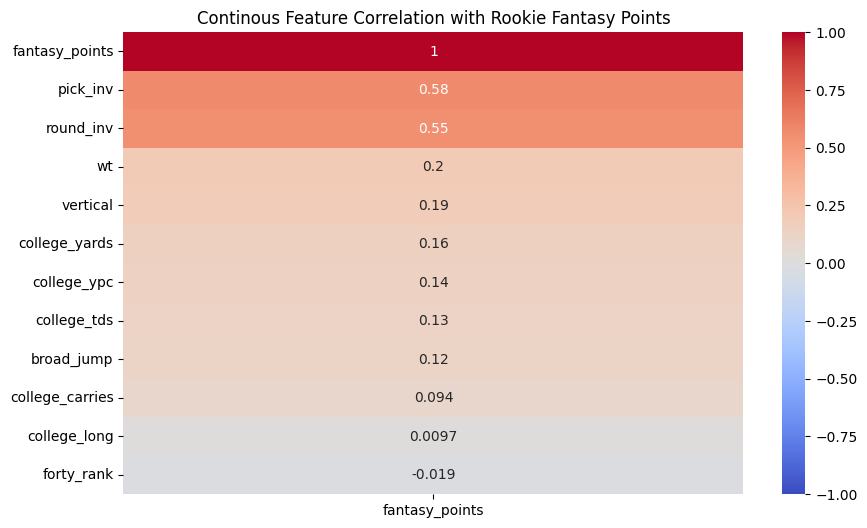

In [ ]:
# heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr[['fantasy_points']].sort_values(by='fantasy_points', ascending=False),
            annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Continous Feature Correlation with Rookie Fantasy Points")
plt.show()

Initial observations of the heatmap show that draft pick and round order show the highest correlation to a running back's rookie fantasy points. This makes sense in the real world as typically the draft position is a summary signal of an NFL team's evaluation of a player's talent (on film and not just via statistics) and opportunity.

Weight (wt) and vertical combine measurements are the highest correlated combine features with college yards and ypc as the highest college stat features.

One very surprising observation is that **forty_rank** is the least correlated with fantasy points. This is particularly surprising becasue the 40 Yard Dash is often the most popular combine measurement that NFL fans follow consistent of each player sprinting for their fastest 40 yard dash time. One would think that a RB's straight line speed would help indicate strong performance, but the heatmap shows very little correlation. Although there have been some outliers such as Chris Johnson drafted in 2008 with the 24th overall pick (1st round) with the fastest 40 time recorded with a very successful rookie year, it seems like that was an outlier if we just look at 40 yard dash time solely.

# P4 vs. non-P4 schools

In college football, "Power 4" or "P4" refers to the Big Ten, Southeastern Conference (SEC), Atlantic Coast Conference (ACC) and Big 12. These four conferences collectively control most of the financial revenue, recruitment advantages, and competitive core in the college football world. Historically it is often "better" to go to a P4 school as an athlete for more recognition to make it to the NFL. When doing data analysis, an issue of bias can arise when it comes to considering players that come from smaller or less funded schools. This could be unfair to grade players based on the size of their school or conference if they did not have a fair choice due to background or history before they entered school. Let's split the data from the heatmap into P4 and non-P4 schools to see if certain features are more correlated for P4 athletes vs non P4 ones.

In [ ]:
# Grab the list of unique colleges in our df
df["college"].unique()

array(['Georgia', 'Wisconsin', 'Alabama', 'Nebraska', 'Indiana',
       'Miami (FL)', 'Northern Iowa', 'Florida', 'Michigan St.', 'USC',
       'South Carolina', 'Minnesota', 'Boise St.', 'Florida St.',
       'Auburn', 'Mississippi St.', 'Missouri', 'LSU', 'Ohio St.',
       'Notre Dame', 'San Jose St.', 'Louisiana Tech', 'Utah',
       'Texas Tech', 'UCLA', 'West Virginia', 'Arkansas', 'Navy',
       'Eastern Michigan', 'Washington', 'California', 'Clemson',
       'Stanford', 'Oklahoma', 'Tennessee', 'Toledo', 'Texas',
       'Pittsburgh', 'North Carolina A&T', 'San Diego St.', 'BYU',
       'South Florida', 'Wyoming', 'North Carolina', 'Texas-El Paso',
       'Louisiana', 'Coastal Carolina', 'Houston', 'Utah St.',
       'Oklahoma St.', 'North Carolina St.', 'Penn St.', 'Oregon',
       'Southern Miss', 'Arizona St.', 'Fordham', 'Mississippi',
       'Virginia St.', 'Northwestern', 'Memphis', 'Iowa St.',
       'Florida Atlantic', 'Kentucky', 'Temple', 'Texas A&M', 'Maryland',
    

In [ ]:
# Figure out the P4 vs. non-P4 schools
non_power4_schools = [
    "Ala-Birmingham","Appalachian St.","BYU","Boise St.","Central Florida","Central Michigan",
    "Cincinnati","Coastal Carolina","Eastern Michigan","Florida Atlantic","Fordham","Houston",
    "Louisiana","Louisiana Tech","Marshall","Memphis","Navy","New Hampshire","New Mexico St.",
    "North Carolina A&T","Northern Iowa","Notre Dame","SMU","San Diego St.","San Jose St.",
    "South Dakota St.","South Florida","Southern Miss","Temple","Texas-El Paso","Toledo",
    "Troy","Tulane","Utah St.","Virginia St.","Wyoming"
]

# Group the colleges to P4 vs. non-P4 schools
df["p4_status"] = df["college"].apply(lambda x: "Non-Power 4" if x in non_power4_schools else "Power 4")

In [ ]:
# Question: How many players are from P4 and non-P4 schools?
df["p4_status"].value_counts()

Power 4        177
Non-Power 4     56
Name: p4_status, dtype: int64

There are more Power 4 RBs drafted total than Non-Power 4, this makes sense due to the P4's prestige and quantity of schools.

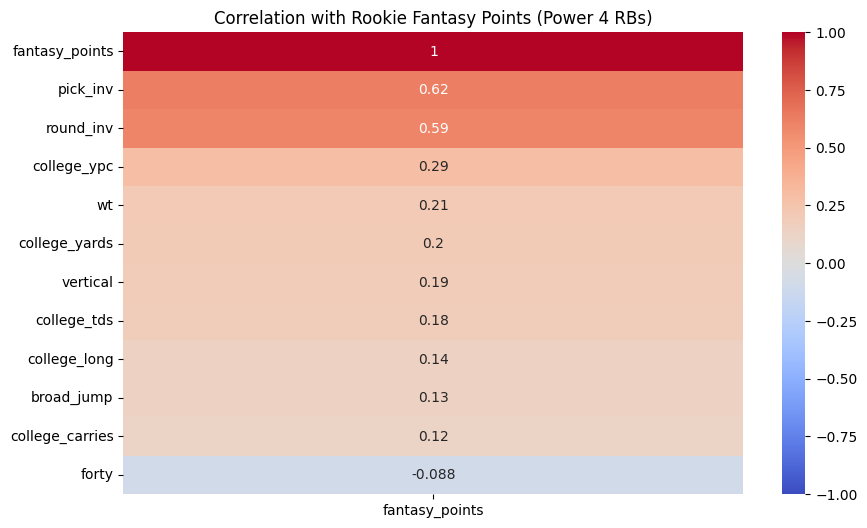

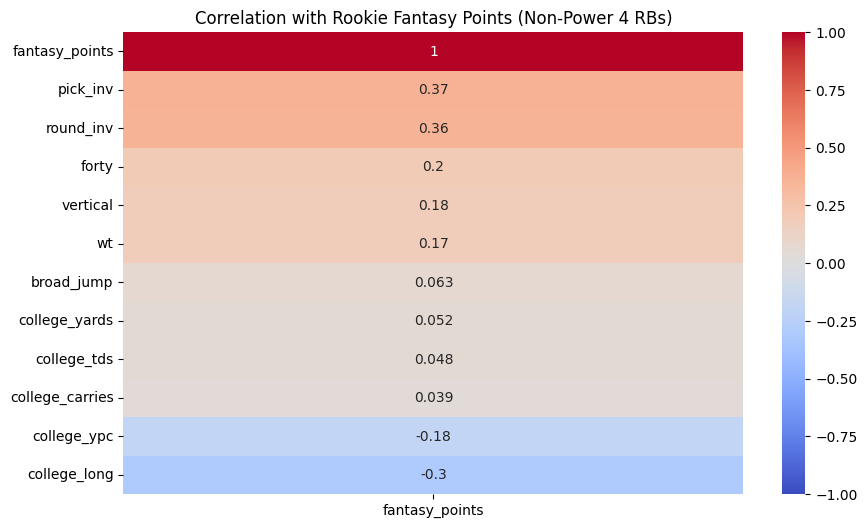

In [ ]:
# Recreate the Correlation Heatmaps: One for P4 RBs and one for non-P4 RBs
for status in ["Power 4", "Non-Power 4"]:
    subset = df[df["p4_status"] == status].copy()

    numeric_subset = subset.select_dtypes(include=['float64','int64'])[target_columns].drop(columns=['cone', 'shuttle', 'bench']).dropna()
    numeric_subset['round_inv'] = numeric_subset['round'].max() - numeric_subset['round'] + 1
    numeric_subset['pick_inv'] = numeric_subset['pick'].max() - numeric_subset['pick'] + 1
    numeric_subset = numeric_subset.drop(['pick','round'], axis=1)

    corr = numeric_subset.corr()

    # Plot the Results
    plt.figure(figsize=(10,6))
    sns.heatmap(
        corr[['fantasy_points']].sort_values(by='fantasy_points', ascending=False),
        annot=True, cmap="coolwarm", vmin=-1, vmax=1
    )
    plt.title(f"Correlation with Rookie Fantasy Points ({status} RBs)")
    plt.show()

We see that vertical and weight (wt) are still the two leading correlating attributes from the combine, but they are still relatively less than the pick order. It is interesting to see that college stats are more correlated for P4 players. This could be because in non-P4 games, there are many opportunities for RBs to "stat pad" against lesser competition, so with higher variance in smaller schools could cause it to be less correlated with NFL rookie year success.

Comparing P4 vs non-P4 heatmaps of the quantitative variables against rookie fantasy, we notice some differing things. First we see a stronger correlation in the pick/round selection for Power 4 schools (0.62 and 0.59) than non-Power 4 (0.37 and 0.36). This makes sense as it is very common for P4 RBs to be selected earlier and have more success coming from larger schools with more media exposure, stronger college competition, and higher talent evaluations. Non-P4 RBs typically get selected later regardless, so the pick order does not correlate as highly to success since NFL scouts may miss talent from smaller schools and the variance is much higher since not many non-P4 RBs get selected in earlier rounds. We can plot this hypothesis as well to verify below.

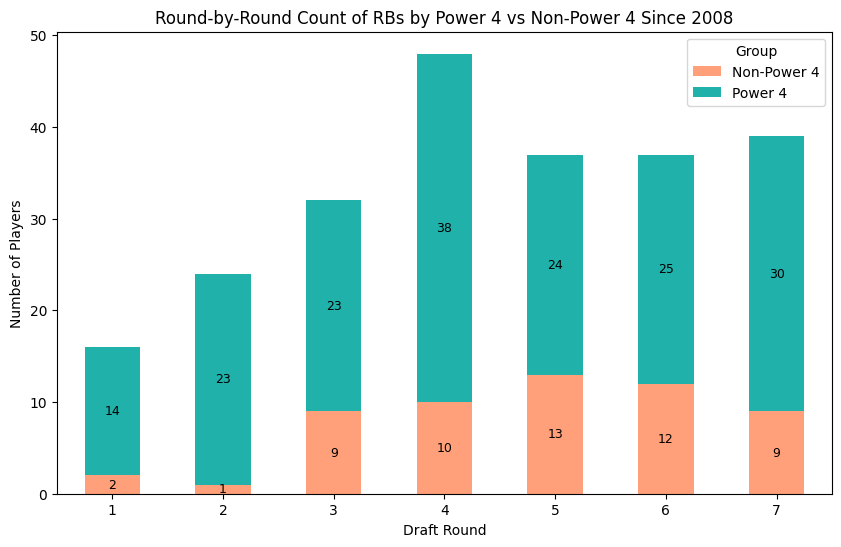

In [ ]:
round_counts = df.groupby(['round', 'p4_status']).size().unstack(fill_value=0)

ax = round_counts.plot(kind='bar', stacked=True, figsize=(10,6), color=['#FFA07A','#20B2AA'])
plt.xlabel('Draft Round')
plt.ylabel('Number of Players')
plt.title('Round-by-Round Count of RBs by Power 4 vs Non-Power 4 Since 2008')
plt.legend(title='Group')

plt.xticks(rotation=0)

# Add count labels inside each bar
for i, row in enumerate(round_counts.values):
    bottom = 0
    for val in row:
        if val > 0:
            ax.text(i, bottom + val/2, str(val), ha='center', va='center', color='black', fontsize=9)
        bottom += val
plt.show()

Based on the stacked bar chart below, we can see that only three non-P4 RBs have been selected in the first two rounds. A larger number of Non-P4 RBs are selected in the third or later.

Now we will look at the average fantasy points of RBs in relation to their relative NFL Draft order. For example the "RB1" is considered to be the first running back drafted in their NFL draft class. In 2023, the RB1 was Bijan Robinson in Round 1 Pick 8. In 2024, the RB1 was Jonathon Brooks in Round 2 Pick 46.

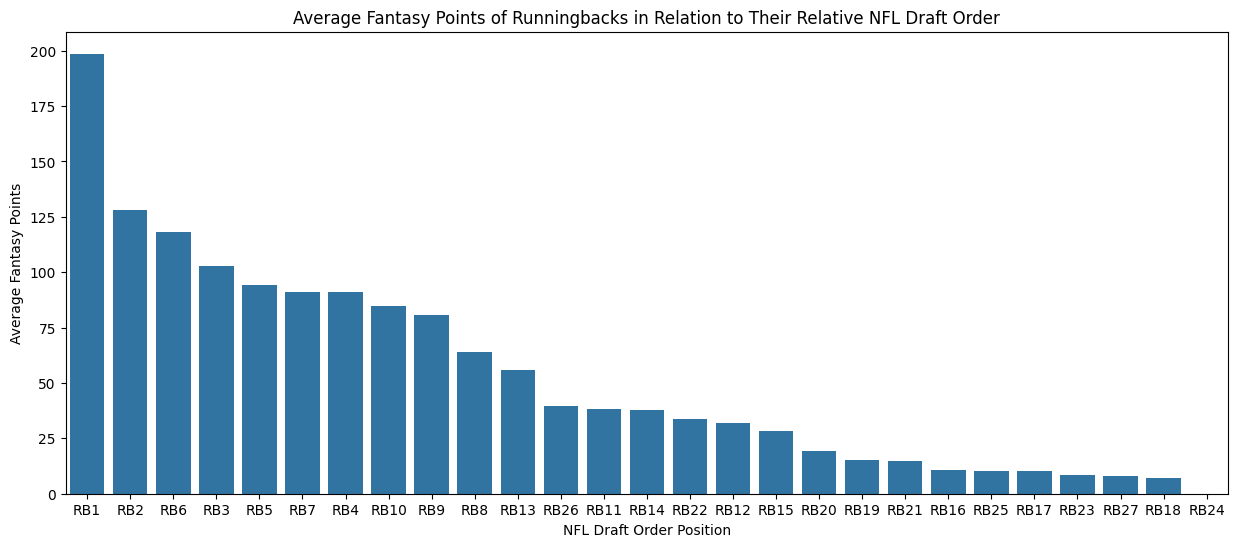

In [ ]:
avg_fantasy_points = df.groupby('position_rank')['fantasy_points'].mean().reset_index()
avg_fantasy_points.sort_values(by='fantasy_points', ascending=False, inplace=True)

plt.figure(figsize=(15,6))
sns.barplot(
    x = avg_fantasy_points['position_rank'],
    y = avg_fantasy_points['fantasy_points']
)
plt.title('Average Fantasy Points of Runningbacks in Relation to Their Relative NFL Draft Order')
plt.ylabel('Average Fantasy Points')
plt.xlabel('NFL Draft Order Position')
plt.show()

Although this could be slightly obvious, the first RB taken is typically has the most successful rookie season! However, what is interesting is right after the first RB. After RB1 there is a large drop off in average performance, and after RB3 we actually see a plateau of performance until around RB10. This could suggest in fantasy drafts to treat RBs outside the top 2 as very similar and not "reach" into the hype of other rookie RBs on average. Let's go one level deeper and see if we can understand how scores are distributed within each position ranking. To do this, we'll try a violin plot.

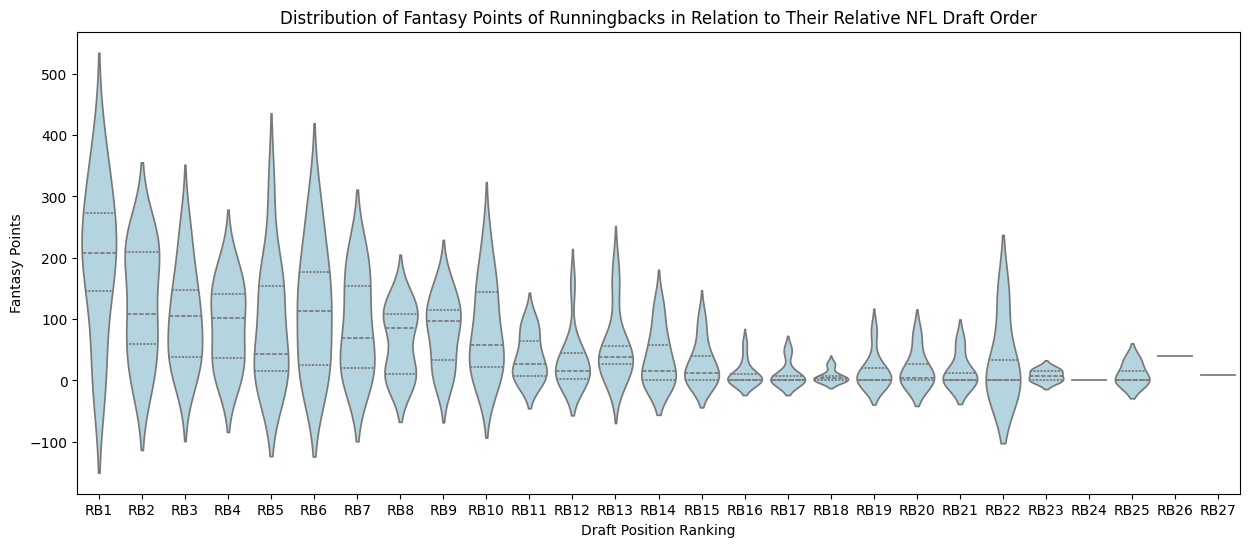

In [ ]:
plt.figure(figsize=(15,6))
sns.violinplot(
    x='position_rank',
    y='fantasy_points',
    data=df,
    density_norm='width',
    inner='quartile',
    color='lightblue'
)

plt.title('Distribution of Fantasy Points of Runningbacks in Relation to Their Relative NFL Draft Order')
plt.ylabel('Fantasy Points')
plt.xlabel('Draft Position Ranking')
plt.show()

So the violin plot shows a lot more variance than the bar chart showed! Namely, although the average for RB2 through RB8 is realtively consistent, RB2's have a much higher upper quartile (around 200 fantasy points) than all the other positions. It is clear that RB1 is going to be the best, but the violin version of the chart shows how RB2's have some "boom" potential as well.